# Notebook demonstrating fitting of $hrz0$ to site data
The below code shows how to use data from fixed-tilt experiments to compute the free parameter $hrz0$. The dust distribution is currently assumed and its parameters are defined in the file `parameters_qut_experiments.xlsx`.

In [1]:
import numpy as np
import soiling_model.base_models as smb
import soiling_model.utilities as smu
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import (rcParams,dates)
import pickle
import copy
rcParams['figure.figsize'] = (10, 7)
# %matplotlib qt

mle_save_file = "results/mle_fitting_results"
reflectometer_angle = 15 # angle of incidence of reflectometer
k_factor = 2.404 # calibration factor for TSP measurements in experiments
second_surf = False # use first surface model
d = "data/public/qut_experiments/"
files = ['experiment_20170807_20170811_cinque.xlsx','experiment_20170828_20170901_cinque.xlsx',\
    'experiment_20170905_20170913_cinque.xlsx','experiment_20170915_20170921_cinque.xlsx']
training_intervals = [  np.array(['2017-08-07T00:00:00','2017-08-10T00:00:00'],dtype=np.datetime64),
                        np.array(['2017-08-28T00:00:00','2022-09-02T00:00:00'],dtype=np.datetime64),
                        np.array(['2022-09-05T00:00:00','2022-09-14T00:00:00'],dtype=np.datetime64),
                        np.array(['2022-09-15T00:00:00','2022-09-22T00:00:00'],dtype=np.datetime64)]
parameter_file = d+"parameters_qut_experiments.xlsx"

## Multiple experiment fitting example

In [2]:
train_experiments = [0,1] # indices for training experiments from 0 to len(files)
train_mirrors = ["Mirror_1","Mirror_2"] # which mirrors within the experiments are used for training
files_experiment = [d+files[ii] for ii in range(len(files))]
Nfiles = len(files_experiment)
k_factors = [k_factor]*Nfiles
incidence_angle = [15.0]*Nfiles
dust_types = ["TSP"]*Nfiles

extract = lambda x,ind: [x[ii] for ii in ind]
files_experiment_train = extract(files_experiment,train_experiments)
k_factors_train = extract(k_factors,train_experiments)
dust_types_train = extract(dust_types,train_experiments)
incidence_angle_train = extract(incidence_angle,train_experiments)
t = [t+1 for t in train_experiments]
training_string = "Training: "+str(train_mirrors)+", Exp: "+str(t)

imodel = smb.fitting_experiment(parameter_file)
sim_data_train = smb.simulation_inputs(files_experiment_train,k_factors=k_factors_train,dust_types=dust_types_train)
reflect_data_train = smb.reflectance_measurements(files_experiment_train,sim_data_train.time,number_of_measurements=9.0,\
    reflectometer_incidence_angle=incidence_angle_train,import_tilts=True,column_names_to_import=train_mirrors)

sim_data_train,reflect_data_train = smu.trim_experiment_data(sim_data_train,reflect_data_train,training_intervals)

sim_data_total = smb.simulation_inputs(files_experiment,k_factors=k_factors,dust_types=dust_types)
reflect_data_total = smb.reflectance_measurements(files_experiment,sim_data_total.time,number_of_measurements=9.0,\
    reflectometer_incidence_angle=incidence_angle,import_tilts=True,column_names_to_import=None)


Importing constants
Importing site data (weather,time). Using dust_type = TSP, test_length = 102 hours
Length of simulation for file data/public/qut_experiments/experiment_20170807_20170811_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing site data (weather,time). Using dust_type = TSP, test_length = 96 hours
Length of simulation for file data/public/qut_experiments/experiment_20170828_20170901_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing dust properties for each experiment
Importing site data (weather,time). Using dust_type = TSP, test_length = 102 hours
Length of simulation for file data/public/qut_experiments/experiment_20170807_20170811_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing site data (weather,time). Using dust_

Text(0.5, 0.98, 'Training Data for file experiment_20170828_20170901_cinque.xlsx')

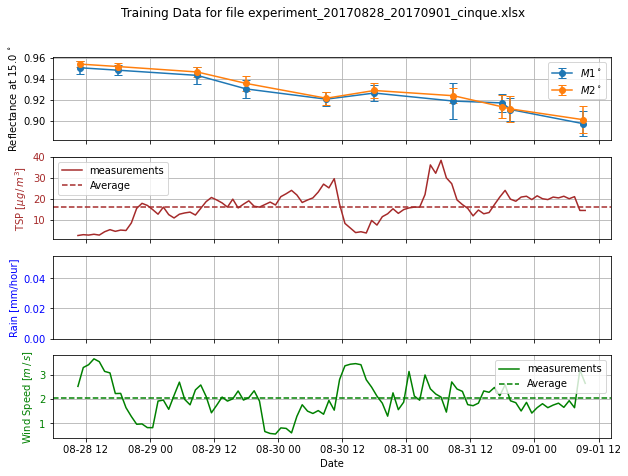

In [3]:
experiment = 1
fig,ax = smu.plot_experiment_data(sim_data_train,reflect_data_train,experiment)
fig.suptitle(f"Training Data for file {files[experiment]}")

Fitting. Use training data only.

In [4]:
imodel.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
hrz0_multi,sse_multi = imodel.fit_hrz0_least_squares(sim_data_train,reflect_data_train)
imodel.update_model_parameters(hrz0_multi)

Setting tilts for 2 experiments
First surface model
First surface model
Fitting hrz0 with least squares ...
... done! 
 hrz0 = 2.072146809852352


Setting tilts for 4 experiments
First surface model
First surface model
First surface model
First surface model
No value for hrz0 supplied. Using value in self.hrz0 = 2.072146809852352.
Calculating deposition velocity for each of the 4 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


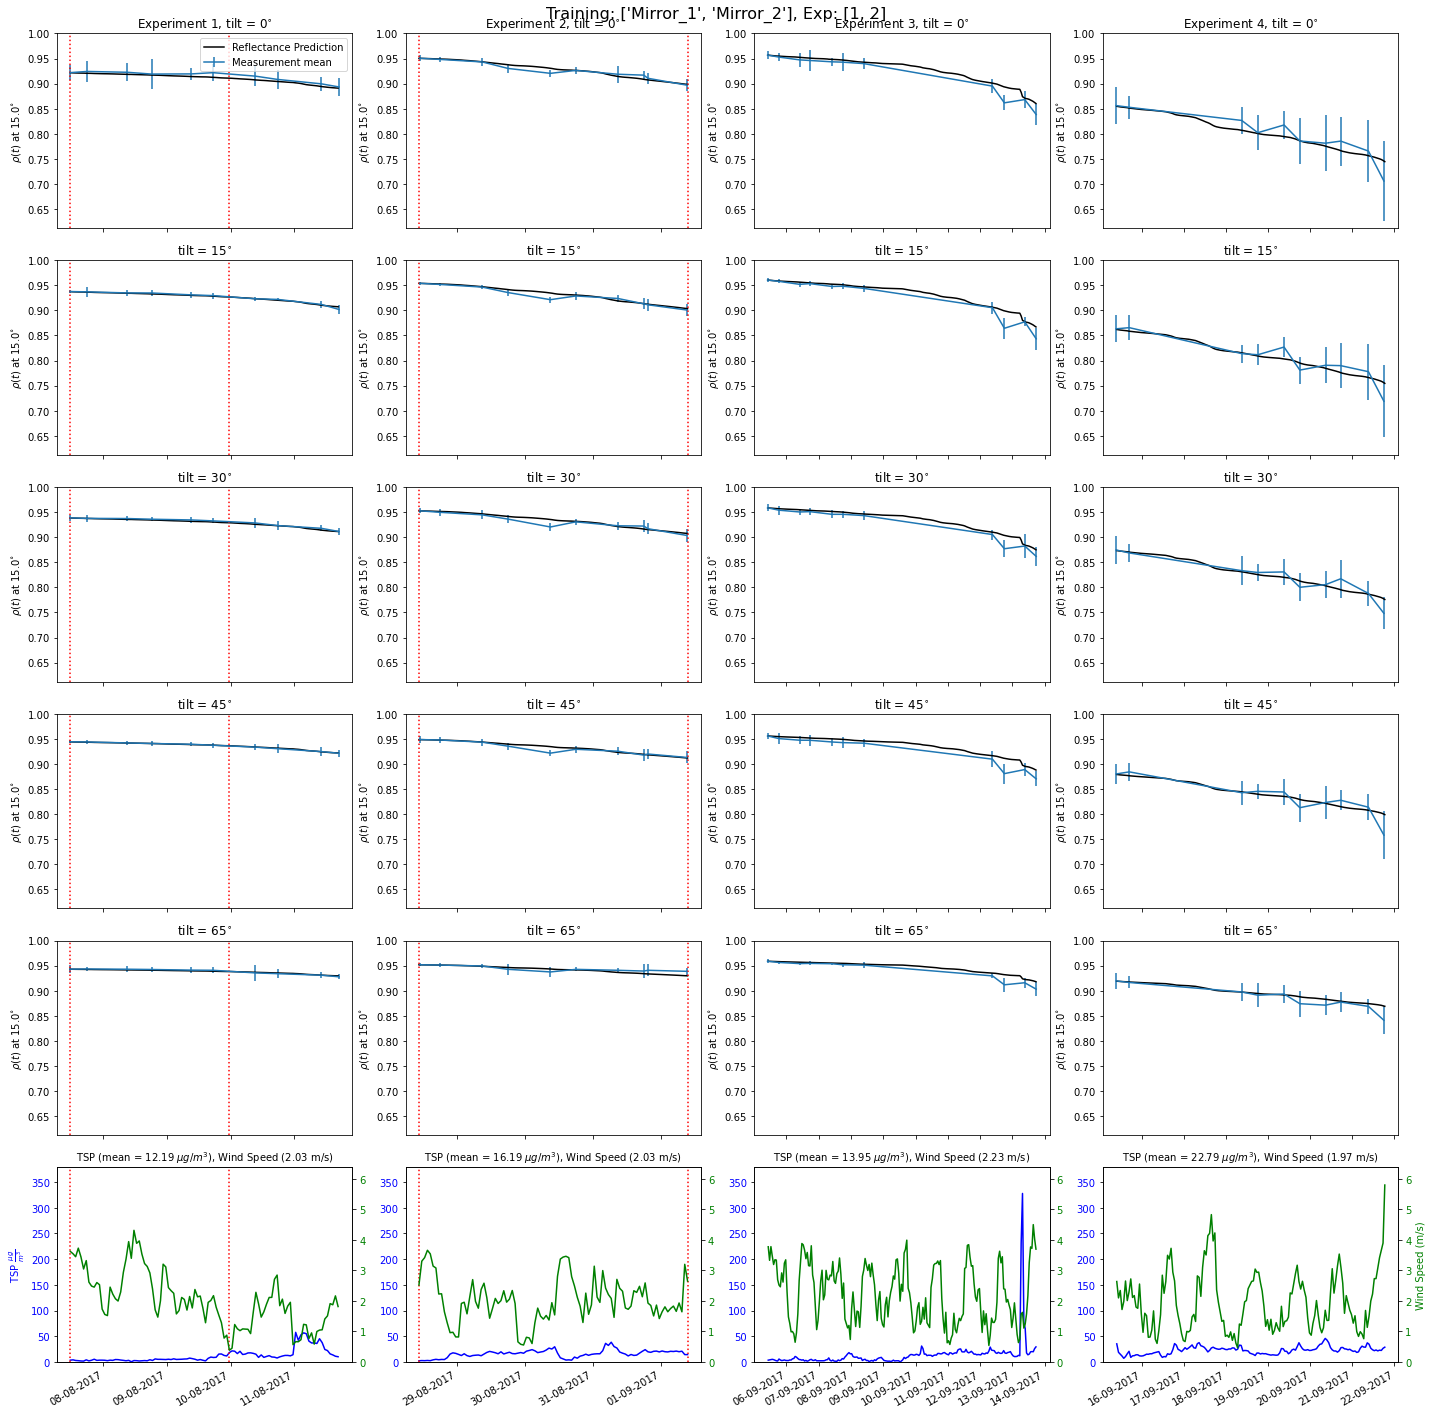

In [5]:
imodel.helios_angles(sim_data_total,reflect_data_total,second_surface=second_surf)
imodel.predict_reflectance(sim_data_total)
fig,ax,_,_,_  = imodel.plot_soiling_factor(sim_data_total,reflectance_data=reflect_data_total,figsize=(20,20),
                                            reflectance_std='measurements',fig_title=training_string,return_handles=True);
for e in sim_data_train.time.keys():
    for a in ax[:,e]:
        a.axvline(x=sim_data_train.time[e][0],ls=':',color='red')
        a.axvline(x=sim_data_train.time[e][-1],ls=':',color='red')